In [1]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#import statsmodels
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
#from xml.etree import ElementTree as ET
#from IPython.core.debugger import set_trace
import seaborn as sns
import random
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import *

In [2]:
# Connect to IB Server
ib=IB()
util.startLoop()
ib.connect('127.0.0.1',7497, clientId= 34)

<IB connected to 127.0.0.1:7497 clientId=34>

In [3]:
#define a function to get IB data. endDate is the last date of the historical data 

def get_data(contract, history, freq, side, endDate):
    
    bar = ib.reqHistoricalData(
        contract,
        endDateTime = endDate,
        durationStr=history,
        barSizeSetting= freq,
        whatToShow=side,
        useRTH=True,
        formatDate=1)
    # use util in ib-insync to convert bar data into pandas dataframe    
    df = util.df(bar)
    # return df 
    return df 

In [4]:
ticker = "BILI"
contract = Contract(symbol = ticker, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract)

# Grab price and volume data from IB
bar = ib.reqHistoricalData(
        contract,
        endDateTime = '',
        durationStr = '2 Y', # we need this rather than '1 Y' for out indicators, maybe there is a better way to do so.
        barSizeSetting = '1 day',
        whatToShow = 'Trades',
        useRTH = True,
        formatDate = 1)

# Convert the bar data into pandas dataframe
df = util.df(bar) # last trade
#check the top 5 rows
df.head()

,date,open,high,low,close,volume,average,barCount
0,2019-03-06,19.00,19.13,18.515,18.66,26719,18.681005,14153
1,2019-03-07,18.40,18.60,17.670,17.80,35377,17.917465,15565
2,2019-03-08,17.18,18.20,17.150,17.94,29643,17.838695,14902
3,2019-03-11,18.12,18.62,17.970,18.60,42685,18.289240,21515
4,2019-03-12,18.71,19.26,18.630,18.90,29899,19.070055,16853


In [5]:
history = '3 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid

ticker1 = 'GS'
ticker2 = 'MS'
ticker3 = 'AAPL'
ticker4 = 'MSFT'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

contract3 = Contract(symbol = ticker3, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract3)

contract4 = Contract(symbol = ticker4, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract4)


#endDate = '20210101 23:59:59' 
endDate = ''

df1 = get_data(contract1, history, freq, side, endDate)
df2 = get_data(contract2, history, freq, side, endDate)
df3 = get_data(contract3, history, freq, side, endDate)
df4 = get_data(contract4, history, freq, side, endDate)


In [6]:
df1.head()

,date,open,high,low,close,volume,average,barCount
0,2018-03-06,264.77,267.87,263.21,266.93,15059,265.7160,10878
1,2018-03-07,262.69,266.43,260.94,265.35,17368,263.8765,12688
2,2018-03-08,266.48,268.10,262.63,266.34,13486,265.3640,9712
3,2018-03-09,268.70,271.09,267.04,270.77,32085,269.5105,20903
4,2018-03-12,271.00,275.31,270.99,273.38,23108,273.4205,15629


In [7]:
df1[ticker1 + '_log'] = df1['close'].apply(lambda x: math.log(x))
df2[ticker2 + '_log'] = df2['close'].apply(lambda x: math.log(x))
df3[ticker3 + '_log'] = df3['close'].apply(lambda x: math.log(x))
df4[ticker4 + '_log'] = df4['close'].apply(lambda x: math.log(x))

df1['log_diff'] = df1[ticker1 + '_log'] - df2[ticker2 + '_log']
df3['log_diff'] = df3[ticker3 + '_log'] - df4[ticker4 + '_log']

In [8]:
df1['log_diff'].head()

0    1.551684
1    1.540106
2    1.542424
3    1.529341
4    1.534852
Name: log_diff, dtype: float64

In [9]:
df3['log_diff'].head()

0   -0.748102
1   -0.763084
2   -0.758342
3   -0.763406
4   -0.756164
Name: log_diff, dtype: float64

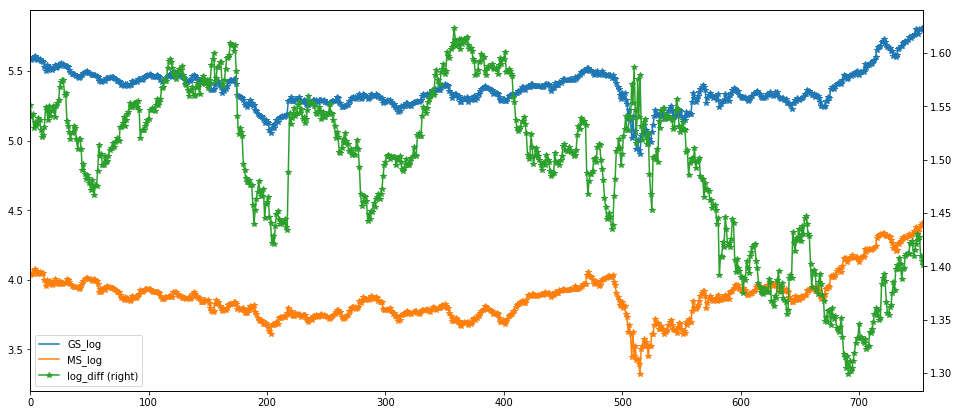

In [10]:
df1[ticker1 + '_log'].plot(figsize = [16,7], marker = "*", legend = True)
df2[ticker2 + '_log'].plot(figsize = [16,7], marker = "*", legend = True)
df1['log_diff'].plot(figsize = [16,7], secondary_y = ['log_diff'], marker = "*", legend = True)

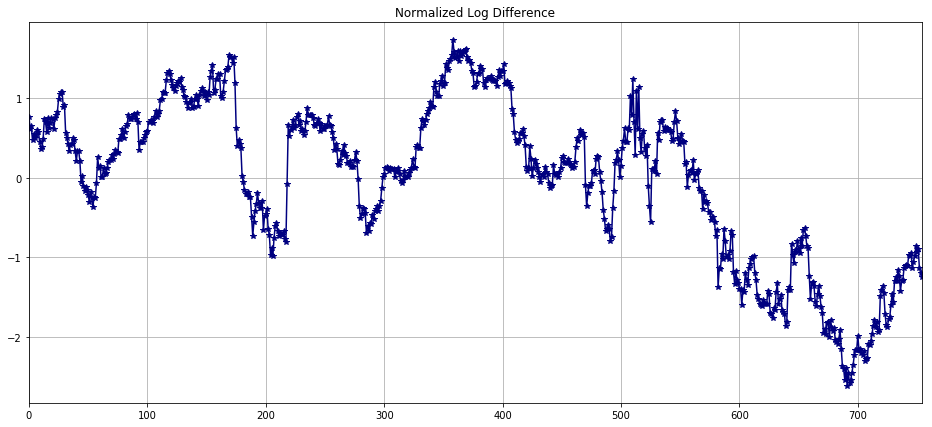

In [11]:
df1['norm_log_diff'] = (df1['log_diff'] - df1.log_diff.mean())/df1.log_diff.std()
df1['norm_log_diff'].plot(figsize = [16,7], secondary_y = ['log_diff'], marker = "*", title ='Normalized Log Difference', grid=True, color ='navy')

 Hedge Ratio = Slope of the Linear Regression Equation: Y = 0.74 X + 2.50


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


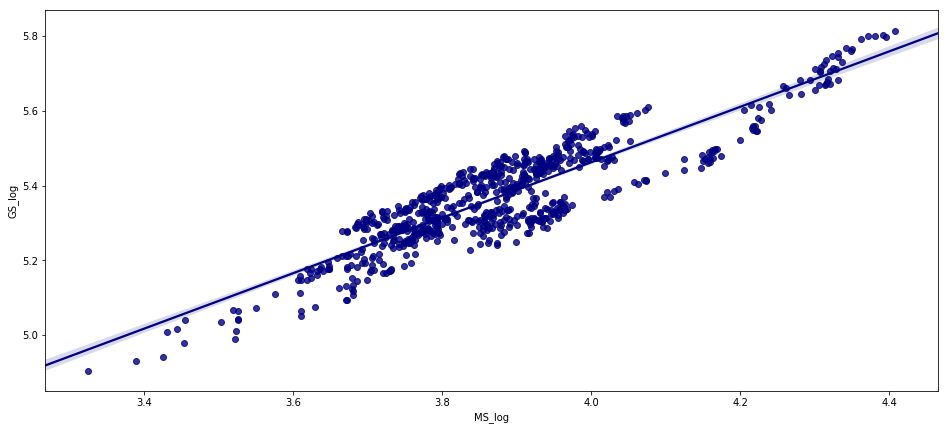

In [13]:
# Fine the hedge ratio with linear regression
#################################### This is IMPORTANT ####################################
# The parameters are different from Duke590 Class Examples.ipynb
#################################### This is IMPORTANT ####################################
slope, intercept, r_value, p_value, std_err = stats.linregress(df2[ticker2 + '_log'],df1[ticker1 + '_log'])

plt.figure(figsize=(16, 7))
p = sns.regplot(x = df2[ticker2 + '_log'], y = df1[ticker1 + '_log'], color = 'navy',
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
print(" Hedge Ratio = Slope of the Linear Regression Equation: Y = " + str('{:.2f}'.format(slope))+ " X + " + str('{:.2f}'.format(intercept)))


In [26]:
Wp = 1/(1+slope) # weight of asset P
Wq = 1-Wp        # weight of asset Q
Wp

0.5741739924948228

In [27]:
# df1[ticker1 + '_log'] = df1['close'].apply(lambda x: math.log(x))
df1['W'] = df1[ticker1 + '_log'] - slope * df2[ticker2 + '_log']

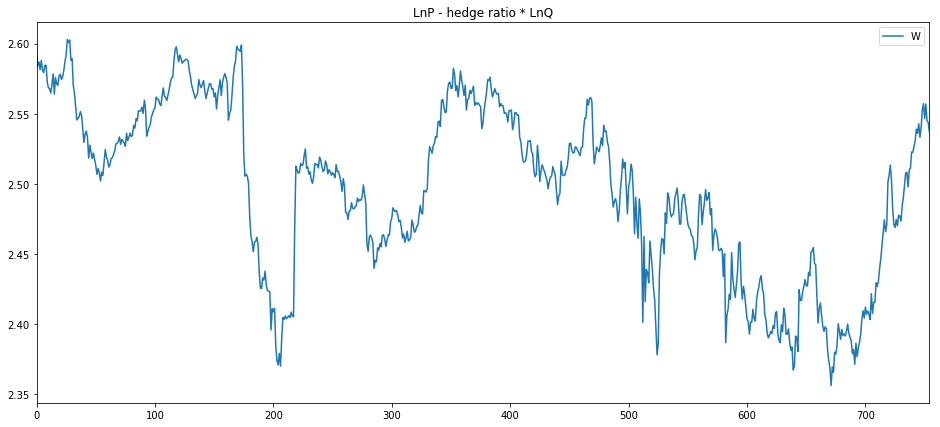

In [28]:
df1['W'].plot(figsize = [16,7], title ='LnP - hedge ratio * LnQ', legend = True)

In [29]:
sigma = np.std(df1['W'])
sigma

0.06066832520273889

In [30]:
mu = df1['W'].mean()
mu

2.4954542780535176

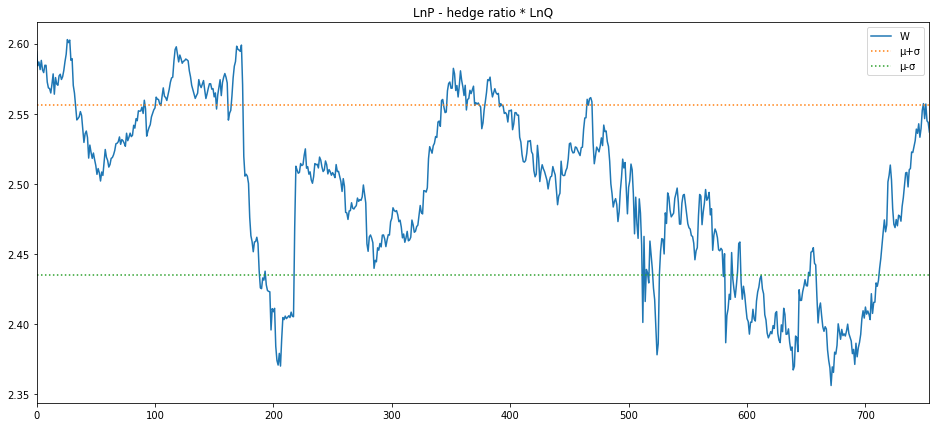

In [31]:
df1['μ+σ'] = mu + sigma
df1['μ-σ'] = mu - sigma
df1['W'].plot(figsize = [16,7], title ='LnP - hedge ratio * LnQ', legend = True)
df1['μ+σ'].plot(figsize = [16,7], linestyle = ':', legend = True)
df1['μ-σ'].plot(figsize = [16,7], linestyle = ':', legend = True)

In [32]:
df1['W'].tail(1)

754    2.536867
Name: W, dtype: float64

In [73]:
# Helper function to get the positions into a dictionary
def get_position():  
    pos={}
    for item in ib.positions():
        pos[item.contract.symbol] = item.position
    return pos

In [74]:
pos = get_position()

In [75]:
pos

{'AAPL': 100.0}

In [76]:
# Trade after market opens every day at 9:30
# For test, I will not use all of my money. 
# The first stock is P and the second one is Q
td = datetime.now()
if [td.hour, td.minute] == [9, 30]:
    pos = get_position()
    
    # Don't have any position, then consider entry
    if ticker1 not in pos.keys() or ticker2 not in pos.keys(): 
        # When W > μ+σ, buy Q and sell P
        if(df1['W'].tail(1) > df1['μ+σ'].tail(1)):
            buyorder = MarketOrder('BUY', 100 * Wq)
            sellorder = MarketOrder('SELL', 100 * Wp)
            ib.placeOrder(contract2, buyorder)
            ib.placeOrder(contract1, sellorder)
        # When W < μ-σ, buy P and sell Q
        if(df1['W'].tail(1) < df1['μ-σ'].tail(1)):
            buyorder = MarketOrder('BUY', 100 * Wp)
            sellorder = MarketOrder('SELL', 100 * Wq)
            ib.placeOrder(contract1, buyorder)
            ib.placeOrder(contract2, sellorder)
    
    # Already have positions, then consider exit
    elif ticker1 in pos.keys() and ticker2 in pos.keys(): 
        # When W = μ, Liquidate all the positions
        if abs(df1['W'].tail(1) - mu) < 0.001:
            if pos[ticker1] > 0 and pos[ticker2] < 0:
                buyorder = MarketOrder('BUY', -pos[ticker2])
                sellorder = MarketOrder('SELL', pos[ticker1])
                ib.placeOrder(contract2, buyorder)
                ib.placeOrder(contract1, sellorder)
            elif pos[ticker1] < 0 and pos[ticker2] > 0:
                buyorder = MarketOrder('BUY', -pos[ticker1])
                sellorder = MarketOrder('SELL', pos[ticker2])
                ib.placeOrder(contract1, buyorder)
                ib.placeOrder(contract2, sellorder)                
                
            